# Nearest apple

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-uxqe27y8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-uxqe27y8
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp

## Set-up

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [5]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

## Monocular Depth Estimation

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


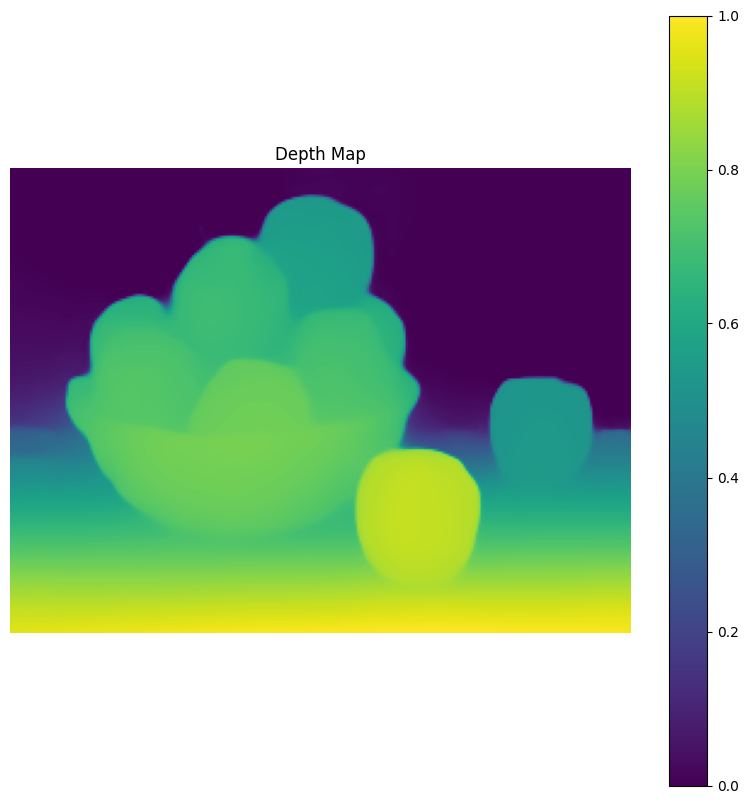

In [310]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms



# Load the pre-trained MiDaS model
model_type = "MiDaS_small"
model = torch.hub.load("intel-isl/MiDaS", model_type)
model.eval()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load and preprocess the image
image_path = "apples-table-with-one-that-says-apple_865967-6424.jpg.jpg"
image = Image.open(image_path)

# Resize the input image to a fixed resolution
fixed_width, fixed_height = 256, 192  # Example target dimensions
resized_image = image.resize((fixed_width, fixed_height))  # For PIL images

# Convert PIL Image to NumPy array and normalize
image_array = np.array(resized_image).astype(np.float32) / 255.0  # Normalize to [0, 1]



# Ensure the image has the correct dimensions (H, W, C)
if image_array.ndim == 2:  # If grayscale, add channel dimension
    image_array = np.expand_dims(image_array, axis=-1)
if image_array.shape[-1] == 1:  # If single channel, duplicate to RGB
    image_array = np.repeat(image_array, 3, axis=-1)

# Transpose dimensions to match PyTorch format (C, H, W)
image_tensor = torch.from_numpy(image_array.transpose(2, 0, 1)).unsqueeze(0).to(device)

# Load the MiDaS model
model_type = "DPT_Large"  # Choose model type
model = torch.hub.load("intel-isl/MiDaS", model_type)
model.to(device).eval()

# Generate the depth map
with torch.no_grad():
    depth_map = model(image_tensor)
    depth_map = depth_map.squeeze().cpu().numpy()

depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Visualize the depth map
plt.figure(figsize=(10, 10))
plt.imshow(depth_map, cmap="viridis")  # Use colormap for better visualization
plt.colorbar()
plt.title("Depth Map")
plt.axis("off")
plt.show()

## Using SAM2 and YOLO for detecting and segmenting the apples from the image

In [309]:
import numpy as np
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from ultralytics import YOLO

# Function to convert a binary SAM mask to a bounding box
def mask_to_bbox(mask):
    """
    Convert a binary mask to a bounding box.
    Returns [x_min, y_min, x_max, y_max].
    """
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return [x_min, y_min, x_max, y_max]

# Function to calculate IoU
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Each box is [x_min, y_min, x_max, y_max].
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

# Load SAM model and generate masks
!wget https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt -P ../checkpoints/
image_path = "apples-table-with-one-that-says-apple_865967-6424.jpg.jpg"
image = Image.open(image_path).convert("RGB")

fixed_width, fixed_height = 256, 192
resized_image = image.resize((fixed_width, fixed_height))
image_array = np.array(resized_image)

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)
masks = mask_generator.generate(image_array)
print(f"Number of masks generated: {len(masks)}")

# Load YOLO model and perform detection
model = YOLO('best-3.pt')
results = model.predict(image_path, conf=0.2, save=True)

# Extract YOLO bounding boxes for all classes
all_boxes = {}
for result in results:
    for box, class_id, confidence in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        class_name = result.names.get(int(class_id), "unknown")
        x_min, y_min, x_max, y_max = box.tolist()
        if class_name not in all_boxes:
            all_boxes[class_name] = []
        all_boxes[class_name].append({
            "bbox": [x_min, y_min, x_max, y_max],
            "confidence": float(confidence)
        })



--2024-12-06 02:51:33--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.47.11, 13.225.47.21, 13.225.47.41, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.47.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_tiny.pt.11’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   159MB/s    in 0.9s    

2024-12-06 02:51:34 (159 MB/s) - ‘../checkpoints/sam2.1_hiera_tiny.pt.11’ saved [156008466/156008466]

Number of masks generated: 22

image 1/1 /content/apples-table-with-one-that-says-apple_865967-6424.jpg.jpg: 448x640 4 0s, 339.9ms
Speed: 3.1ms preprocess, 339.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict9


In [311]:
# matching masks

# YOLO bounding boxes for class '0'
yolo_class_0_boxes = [
    box['bbox'] for box in all_boxes.get('0', [])
]

# Scale YOLO bounding boxes to match SAM dimensions if necessary
orig_width, orig_height = image.size  # Original image dimensions
scaled_yolo_boxes = []
for box in yolo_class_0_boxes:
    scaled_yolo_boxes.append([
        box[0] * (fixed_width / orig_width),  # Scale x_min
        box[1] * (fixed_height / orig_height),  # Scale y_min
        box[2] * (fixed_width / orig_width),  # Scale x_max
        box[3] * (fixed_height / orig_height),  # Scale y_max
    ])

# Compare SAM masks with YOLO bounding boxes
iou_threshold = 0.5  # Minimum IoU threshold for matching
filtered_sam_masks = []

for mask in masks:
    # Convert SAM mask to bounding box
    sam_bbox = mask_to_bbox(mask['segmentation'])

    # Check IoU with YOLO bounding boxes
    for yolo_bbox in scaled_yolo_boxes:
        iou = calculate_iou(sam_bbox, yolo_bbox)
        if iou >= iou_threshold:
            filtered_sam_masks.append(mask)
            break  # No need to check further YOLO boxes for this mask

# Display results
print(f"Number of SAM masks matching YOLO detections: {len(filtered_sam_masks)}")
for i, mask in enumerate(filtered_sam_masks):
    print(f"Filtered Mask {i+1}: Area = {mask['area']}, Bounding Box = {mask['bbox']}")

Number of SAM masks matching YOLO detections: 5
Filtered Mask 1: Area = 2384, Bounding Box = [142.0, 115.0, 51.0, 55.0]
Filtered Mask 2: Area = 1650, Bounding Box = [198.0, 84.0, 41.0, 46.0]
Filtered Mask 3: Area = 1605, Bounding Box = [34.0, 62.0, 48.0, 45.0]
Filtered Mask 4: Area = 1903, Bounding Box = [68.0, 24.0, 46.0, 56.0]
Filtered Mask 5: Area = 2014, Bounding Box = [23.0, 52.0, 59.0, 55.0]


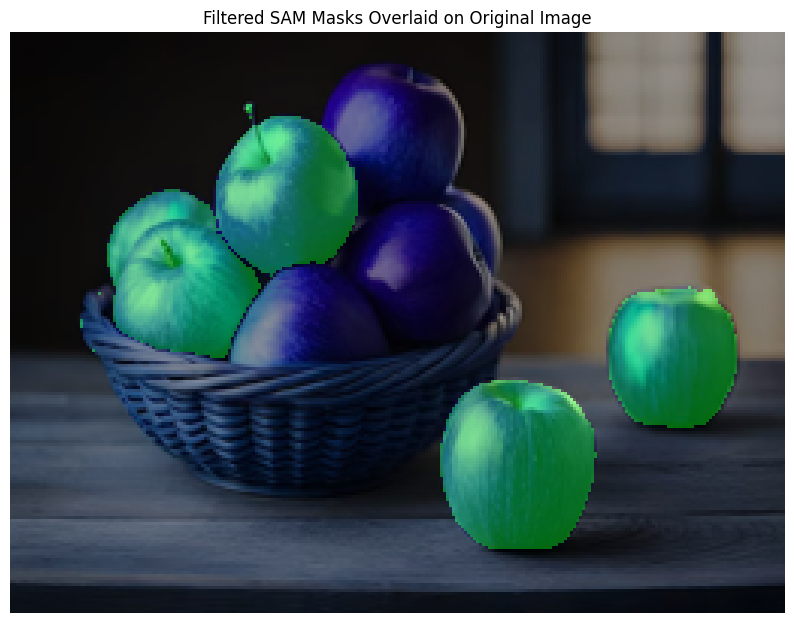

In [312]:
# plotting the filterd out apples

import matplotlib.pyplot as plt
import cv2

# Convert the resized image to a NumPy array if not already
resized_image_array = np.array(resized_image)

# Create an overlay for the filtered masks
overlay = np.zeros_like(resized_image_array, dtype=np.uint8)

# Add each filtered mask to the overlay
for mask in filtered_sam_masks:
    segmentation = mask['segmentation'].astype(np.uint8)  # Binary mask
    segmentation_resized = cv2.resize(segmentation, (resized_image_array.shape[1], resized_image_array.shape[0]))
    overlay[segmentation_resized > 0] = [0, 255, 0]  # Red color for masks

# Blend the original image with the overlay
blended_image = cv2.addWeighted(resized_image_array, 0.6, overlay, 0.4, 0)

# Convert to RGB for displaying with Matplotlib
blended_image_rgb = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(blended_image_rgb)
plt.title("Filtered SAM Masks Overlaid on Original Image")
plt.axis("off")
plt.show()

## Extracting the depth values for each mask containing the apple and comparing their medians (highest median is the nearest object)

Mask [142.0, 115.0, 51.0, 55.0]: Median Depth = 0.90
Mask [198.0, 84.0, 41.0, 46.0]: Median Depth = 0.53
Mask [34.0, 62.0, 48.0, 45.0]: Median Depth = 0.72
Mask [68.0, 24.0, 46.0, 56.0]: Median Depth = 0.67
Mask [23.0, 52.0, 59.0, 55.0]: Median Depth = 0.72
Two Highest Median Depths = [0.8984441, 0.7215192]


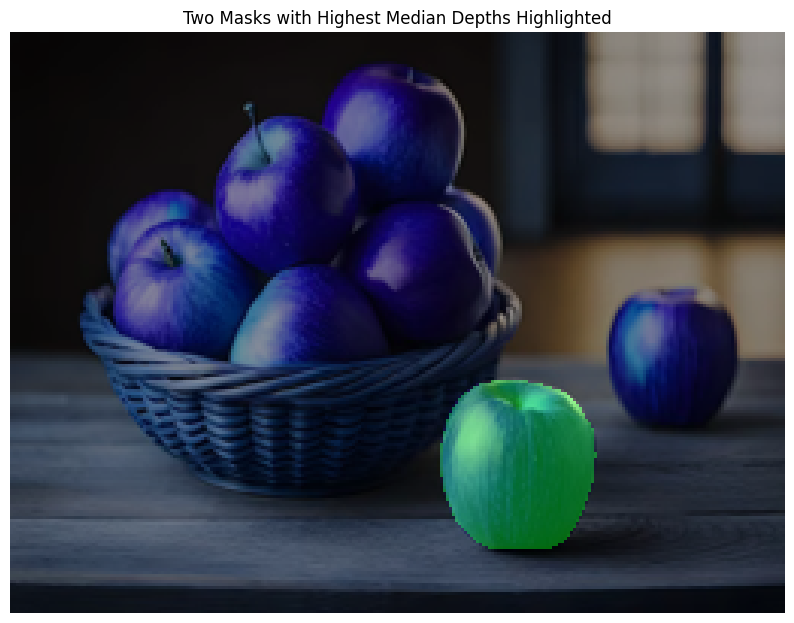

In [313]:
# result:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Store the two highest depths and their corresponding masks
highest_depths = [-float('inf'), -float('inf')]
highest_masks = [None, None]

# Loop through the filtered masks to find the two highest median depths
for mask in filtered_sam_masks:
    segmentation = mask['segmentation'].astype(np.uint8)  # Binary mask
    segmentation_resized = cv2.resize(segmentation, (depth_map.shape[1], depth_map.shape[0]))

    # Extract depth values
    mask_depth_values = depth_map[segmentation_resized > 0]
    median_depth = np.median(mask_depth_values)

    print(f"Mask {mask['bbox']}: Median Depth = {median_depth:.2f}")

    # Update the highest depths and corresponding masks
    if median_depth > highest_depths[0]:  # Update first highest
        highest_depths[1], highest_masks[1] = highest_depths[0], highest_masks[0]  # Shift down
        highest_depths[0], highest_masks[0] = median_depth, segmentation_resized
    elif median_depth > highest_depths[1]:  # Update second highest
        highest_depths[1], highest_masks[1] = median_depth, segmentation_resized

print(f"Two Highest Median Depths = {highest_depths}")

# Create an overlay for the two highest masks
overlay = np.zeros_like(resized_image_array, dtype=np.uint8)

# Highlight the two masks in different colors
if highest_masks[0] is not None:
    overlay[highest_masks[0] > 0] = [0, 255, 0]  # First mask in red


# Blend the overlay with the original image
blended_image = cv2.addWeighted(resized_image_array, 0.6, overlay, 0.4, 0)

# Convert to RGB for Matplotlib
blended_image_rgb = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(blended_image_rgb)
plt.title("Two Masks with Highest Median Depths Highlighted")
plt.axis("off")
plt.show()